In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/train.csv').set_index('id')
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [3]:
len(data)

2190

In [4]:
data.duplicated().sum()

0

In [5]:
data.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [6]:
print('Column vs Number of unique values')
for col in data.columns:
    print(f'**** Column: {col} ****')
    print(f'Number of unique values: {data[col].nunique()}')
    print('-'*50)

Column vs Number of unique values
**** Column: day ****
Number of unique values: 365
--------------------------------------------------
**** Column: pressure ****
Number of unique values: 236
--------------------------------------------------
**** Column: maxtemp ****
Number of unique values: 219
--------------------------------------------------
**** Column: temparature ****
Number of unique values: 198
--------------------------------------------------
**** Column: mintemp ****
Number of unique values: 199
--------------------------------------------------
**** Column: dewpoint ****
Number of unique values: 218
--------------------------------------------------
**** Column: humidity ****
Number of unique values: 49
--------------------------------------------------
**** Column: cloud ****
Number of unique values: 78
--------------------------------------------------
**** Column: sunshine ****
Number of unique values: 120
--------------------------------------------------
**** Column:

## EDA

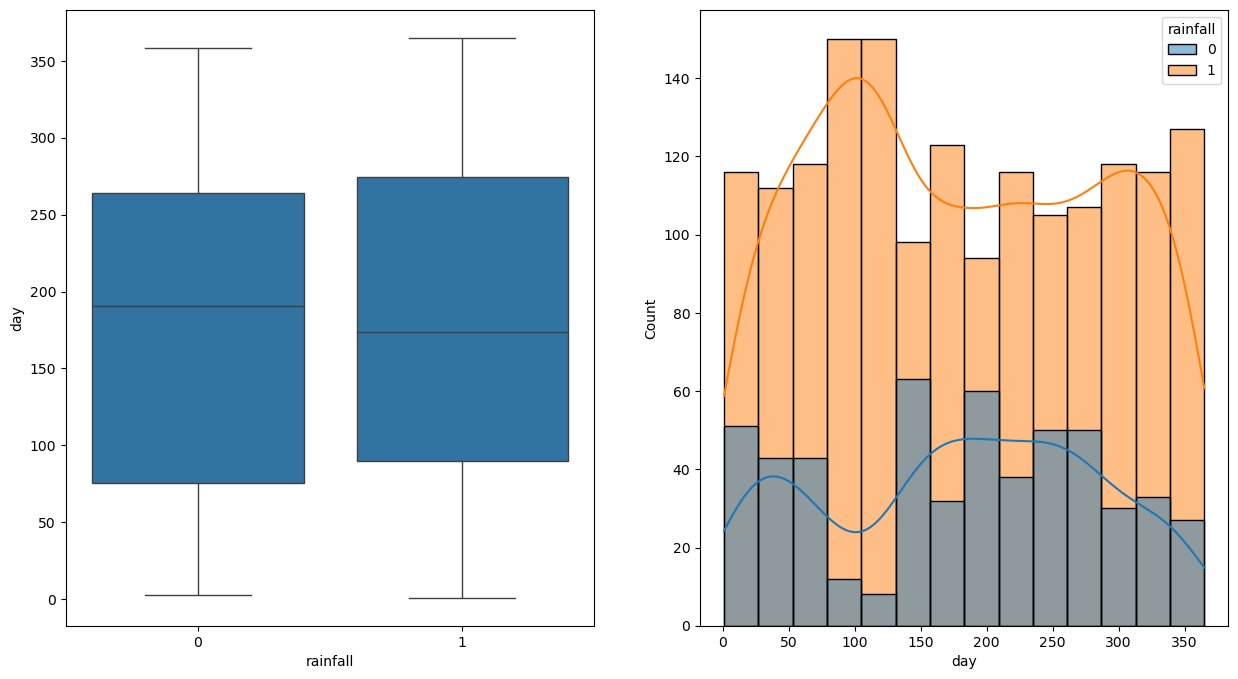

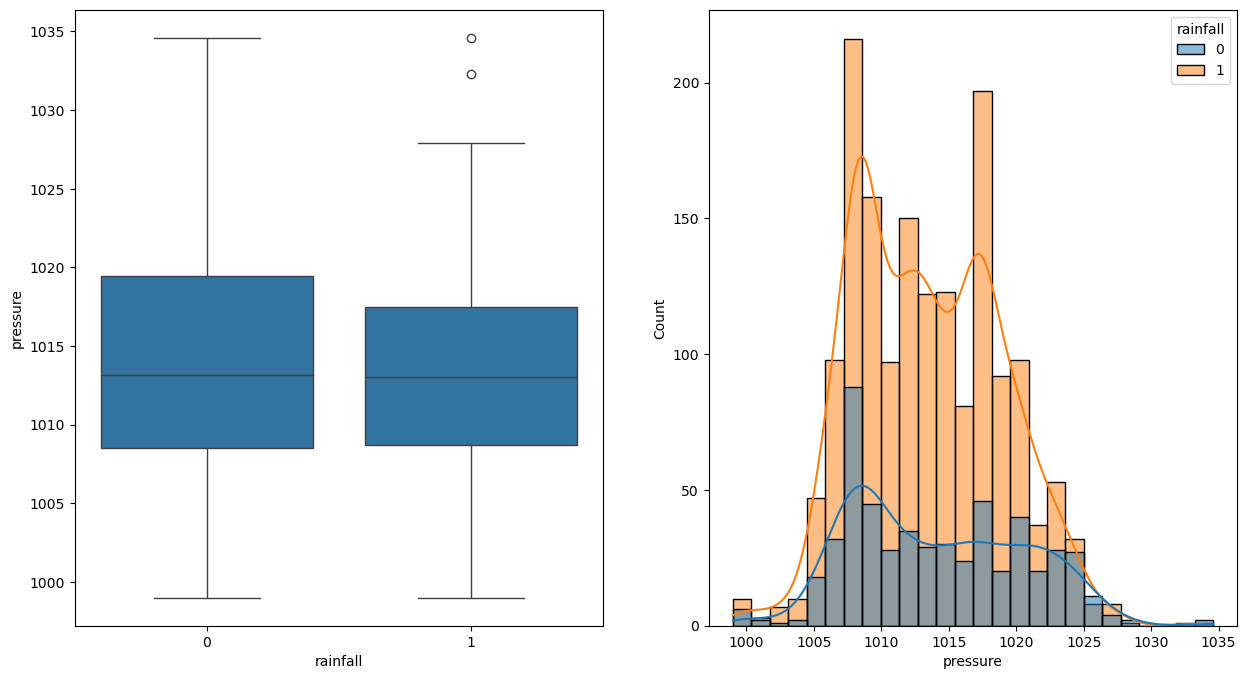

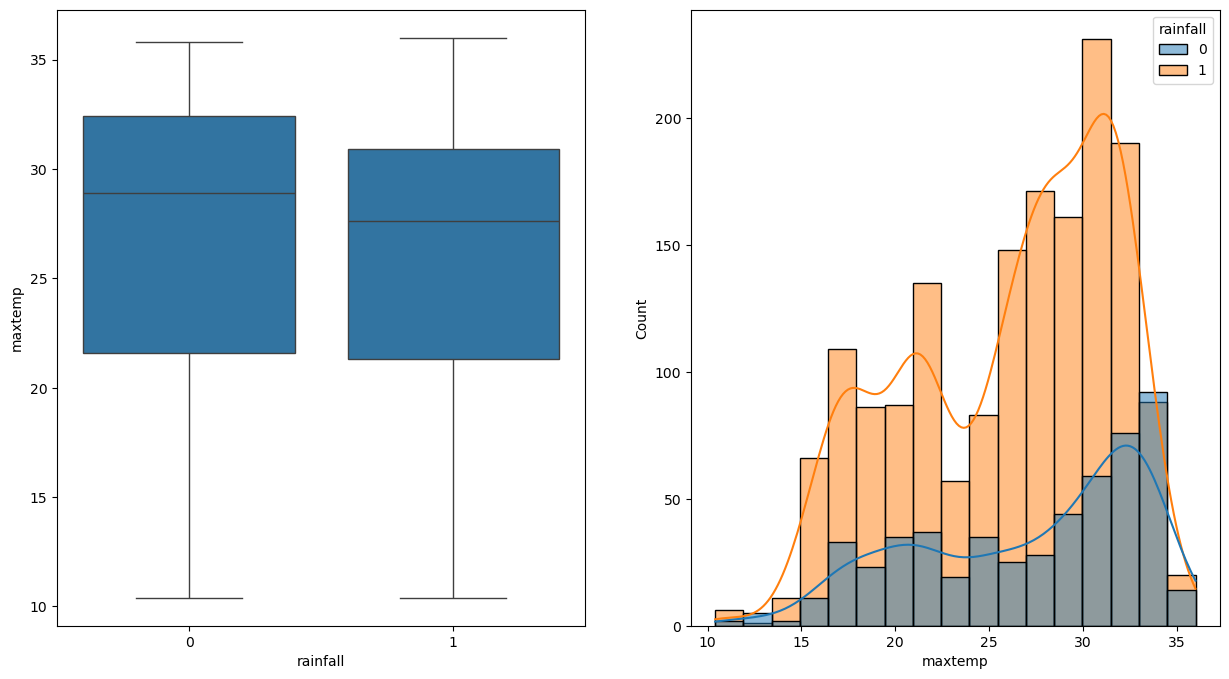

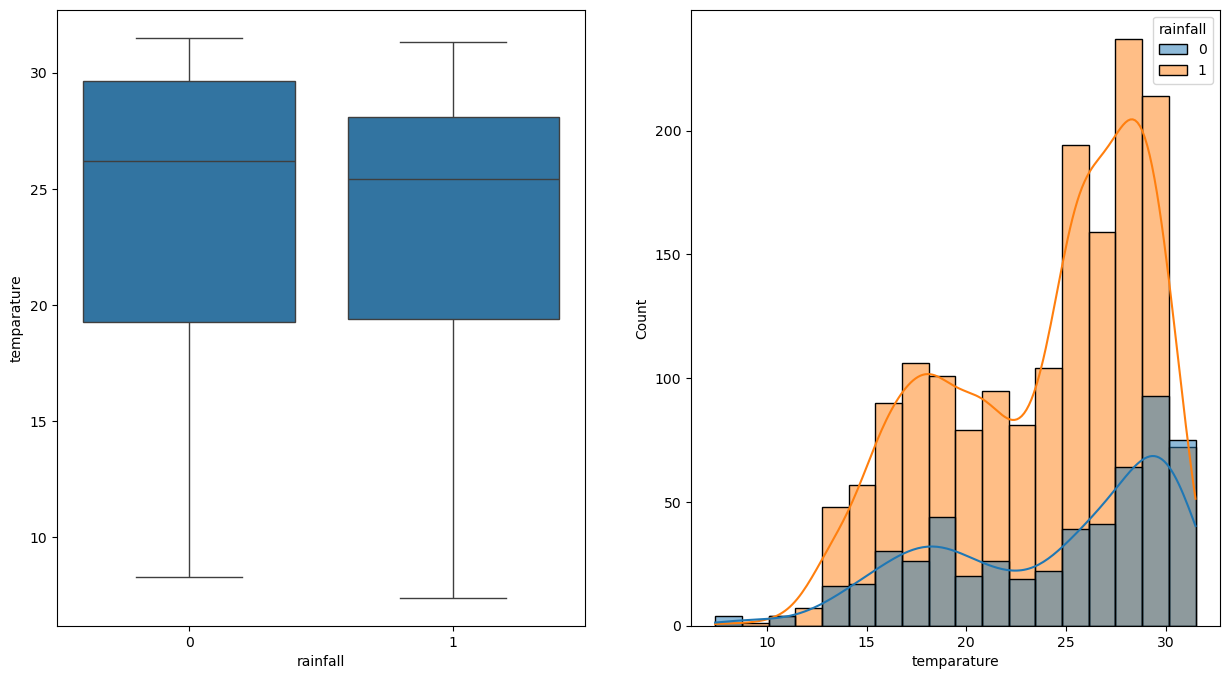

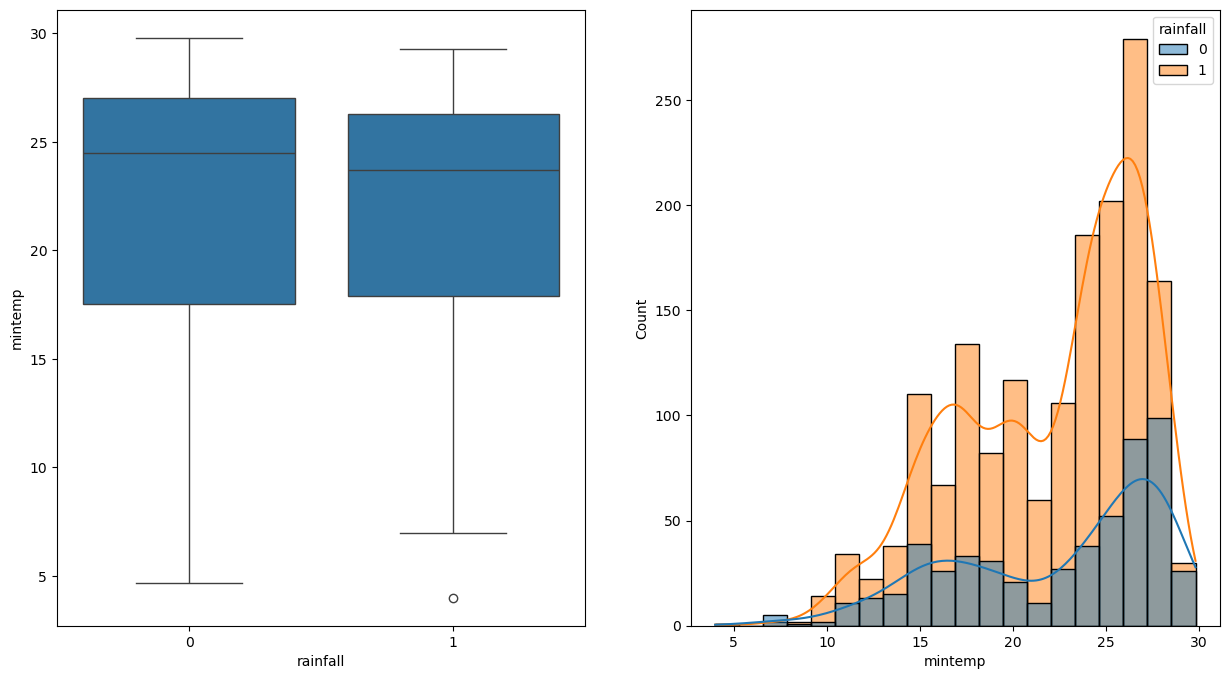

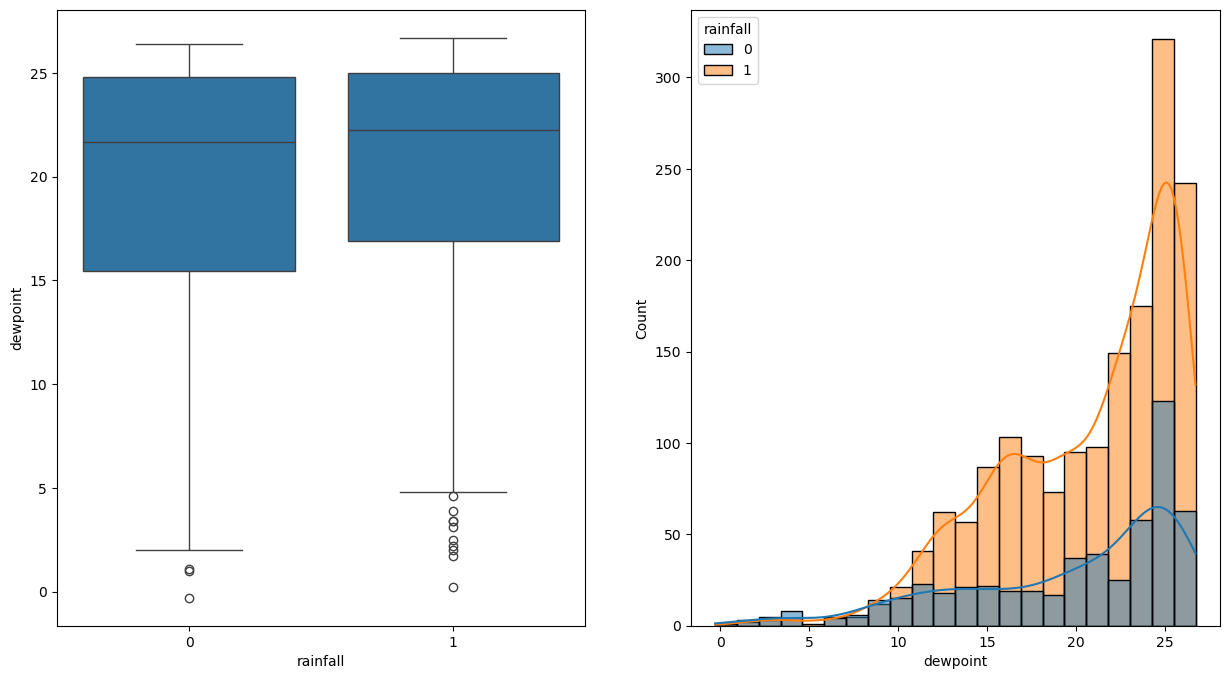

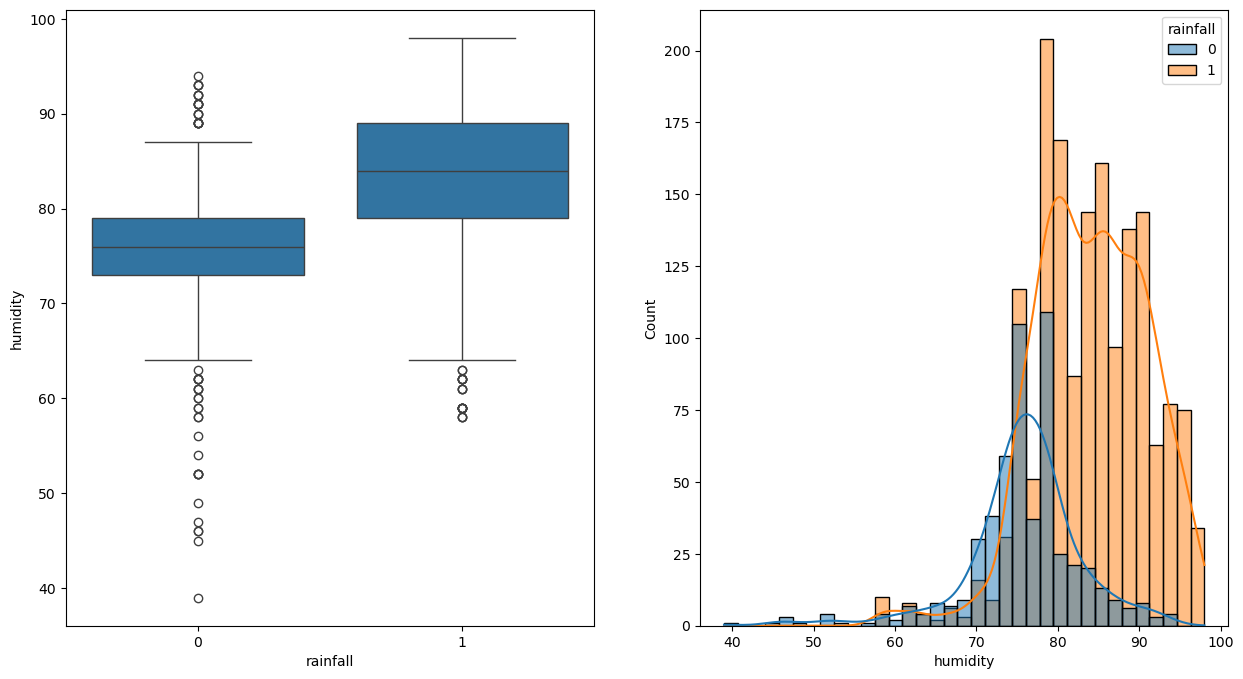

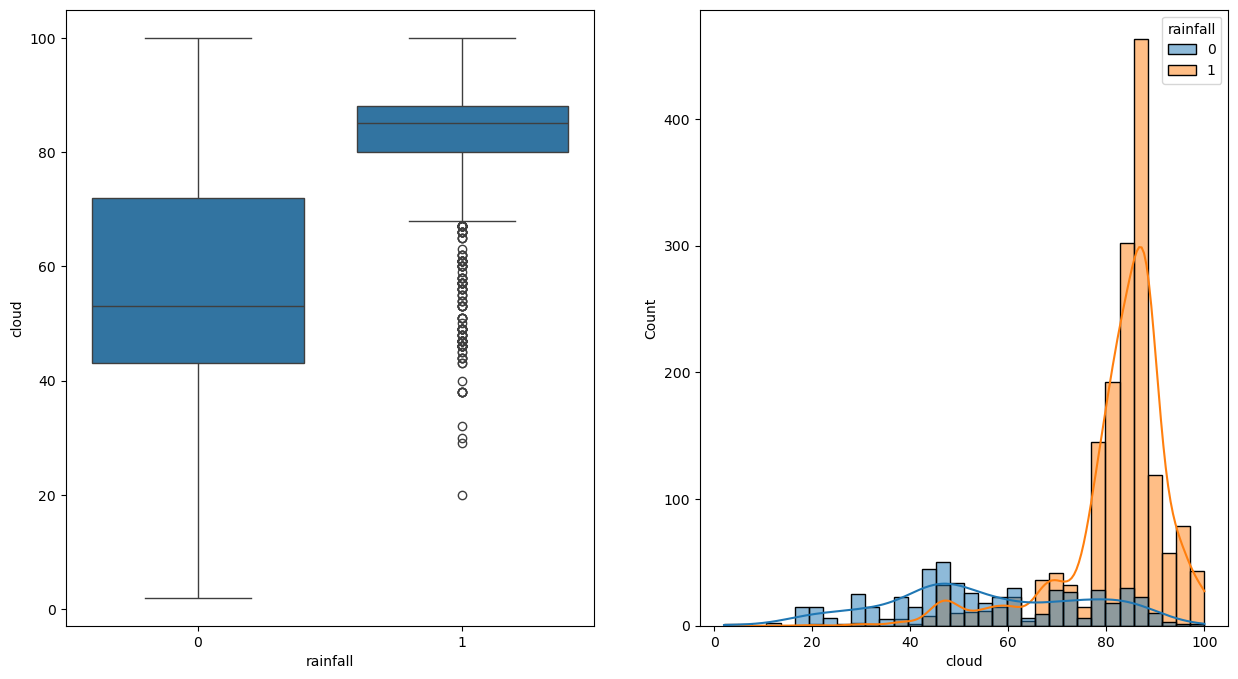

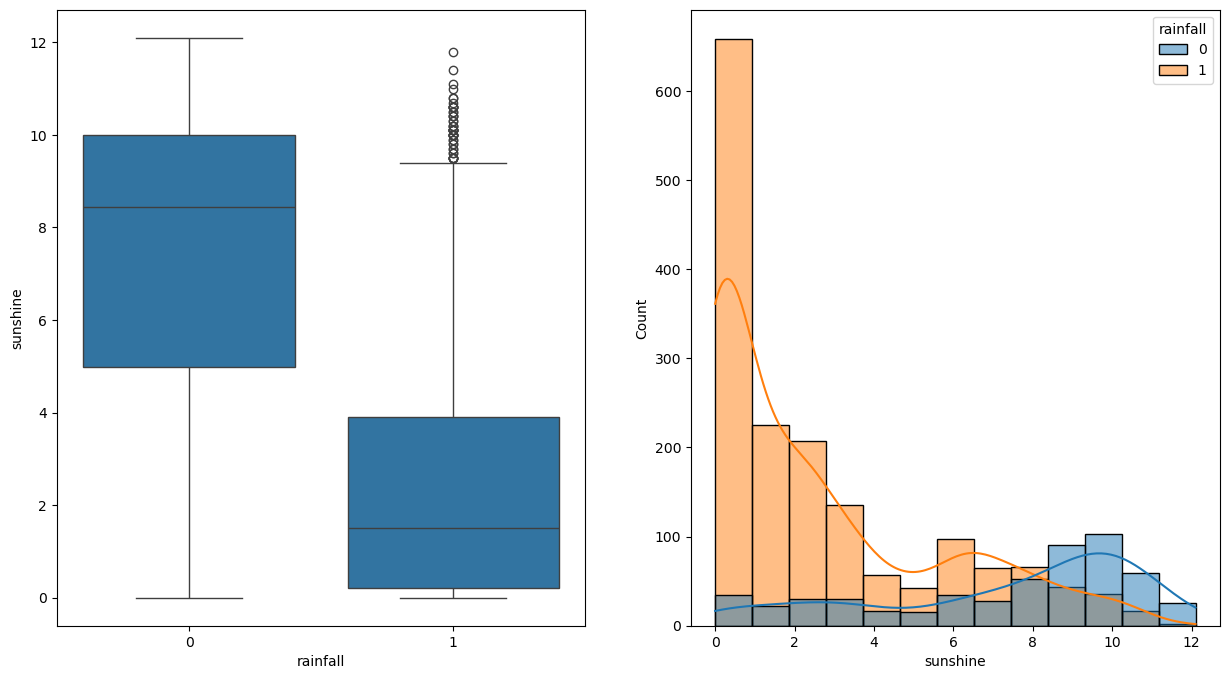

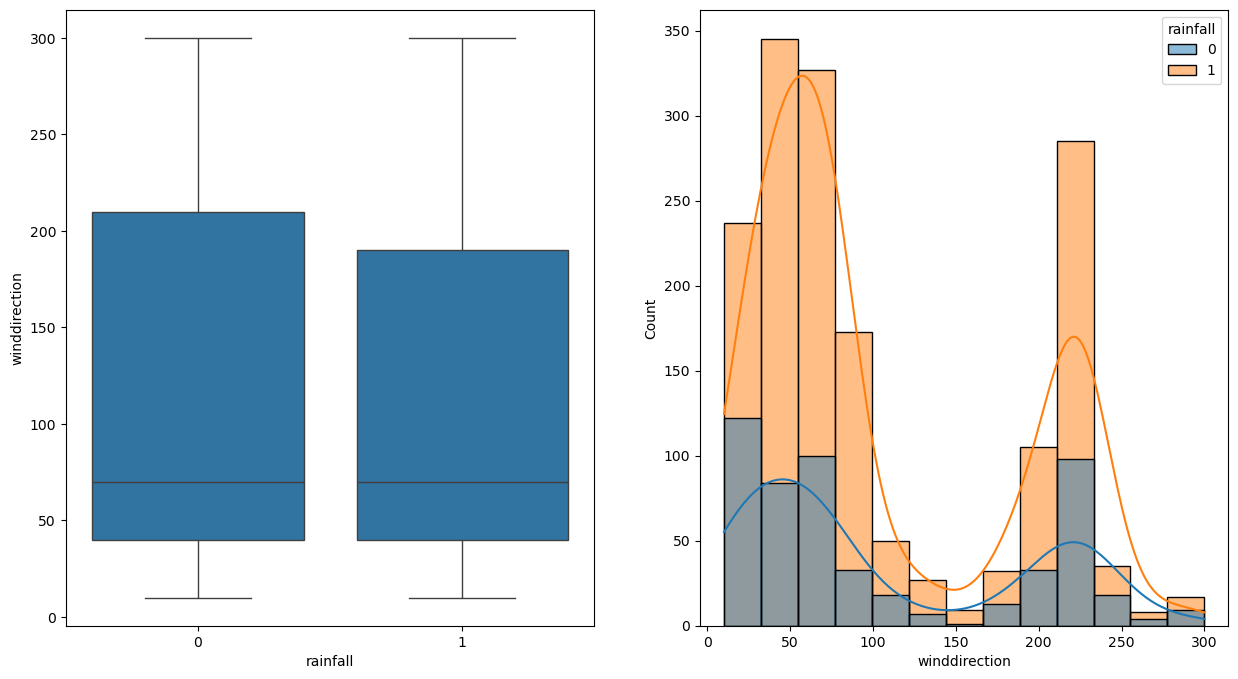

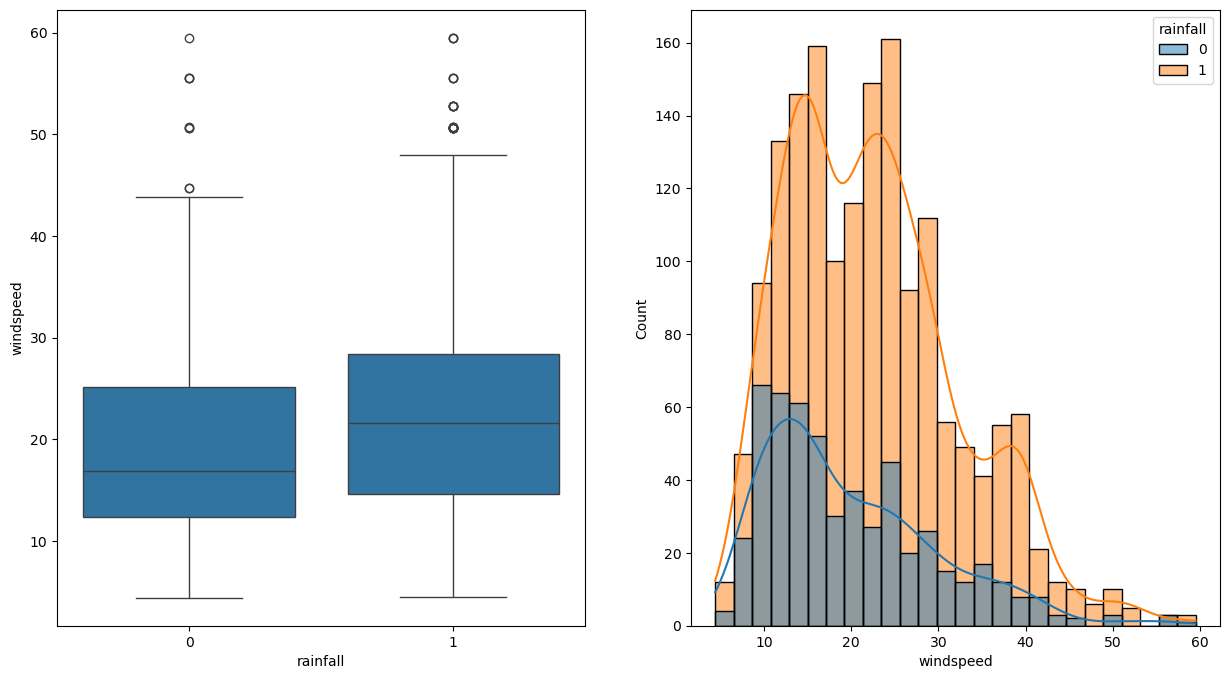

In [7]:
for col in data.columns[:-1]:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=data, y=col, x='rainfall')
    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x=col, hue='rainfall', kde=True)
    plt.show()

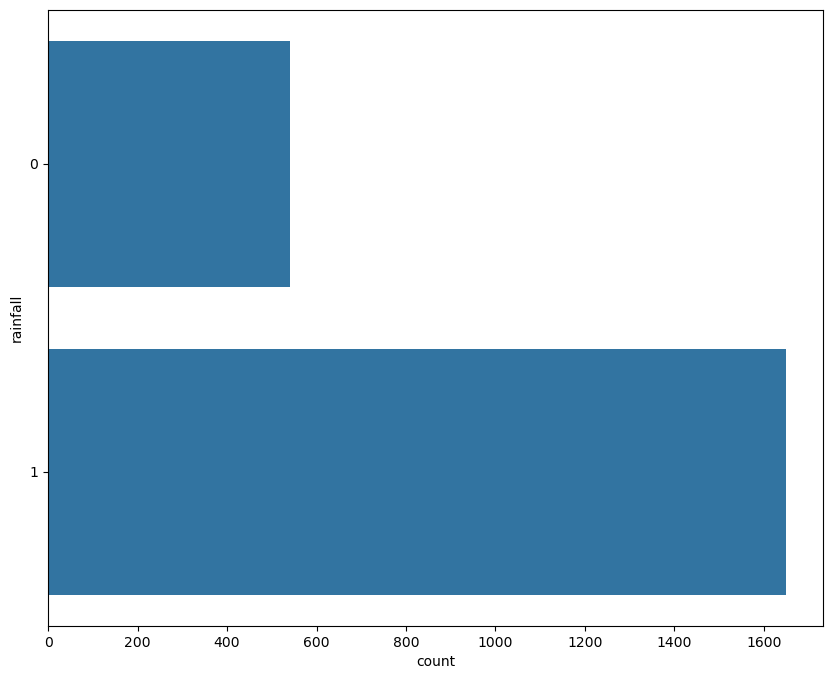

In [8]:
plt.figure(figsize=(10, 8))
sns.countplot(data=data, y='rainfall')
plt.show()

In [9]:
for col in data.columns[:-1]:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

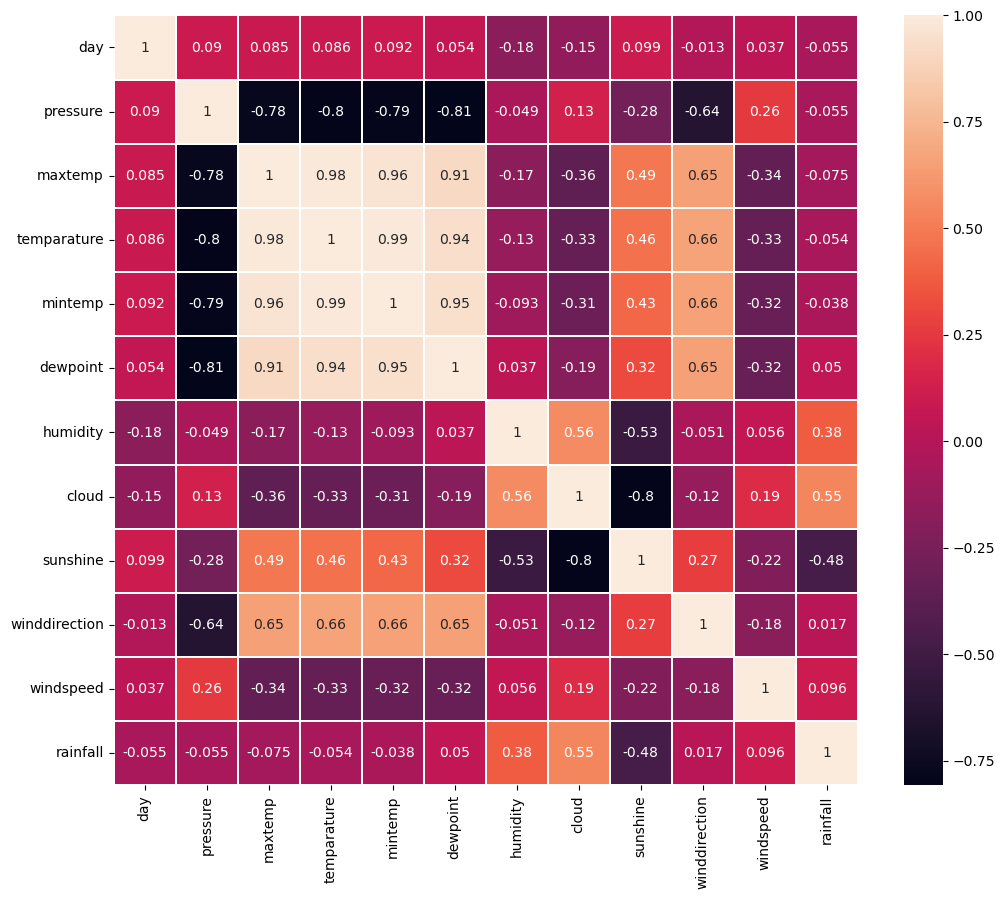

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=data.corr(), annot=True, linewidths=0.2);

In [11]:
data['avgtemp'] = round((data['maxtemp'] + data['temparature'] + data['mintemp']) / 3, 1)
data.drop(columns=['maxtemp', 'temparature', 'mintemp'], axis=1, inplace=True)
data.head()

,day,pressure,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,avgtemp
id,,,,,,,,,,
0,1,1017.4,19.4,87.0,88.0,1.1,60.0,17.2,1,20.6
1,2,1019.5,15.4,95.0,91.0,0.0,50.0,21.9,1,16.3
2,3,1024.1,9.3,75.0,47.0,8.3,70.0,18.1,1,16.7
3,4,1013.4,16.8,95.0,95.0,0.0,60.0,35.6,1,17.6
5,6,1022.7,12.5,79.0,81.0,0.0,20.0,15.7,1,18.6


<Axes: >

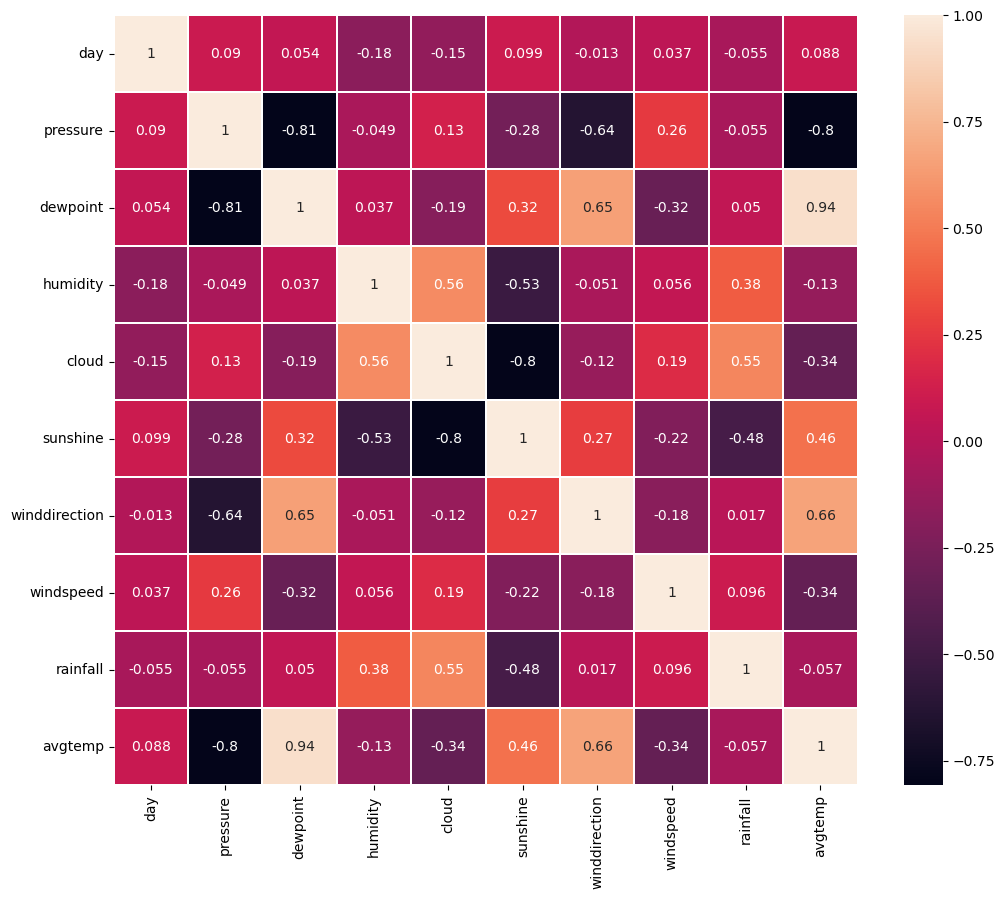

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=data.corr(), annot=True, linewidths=0.2)

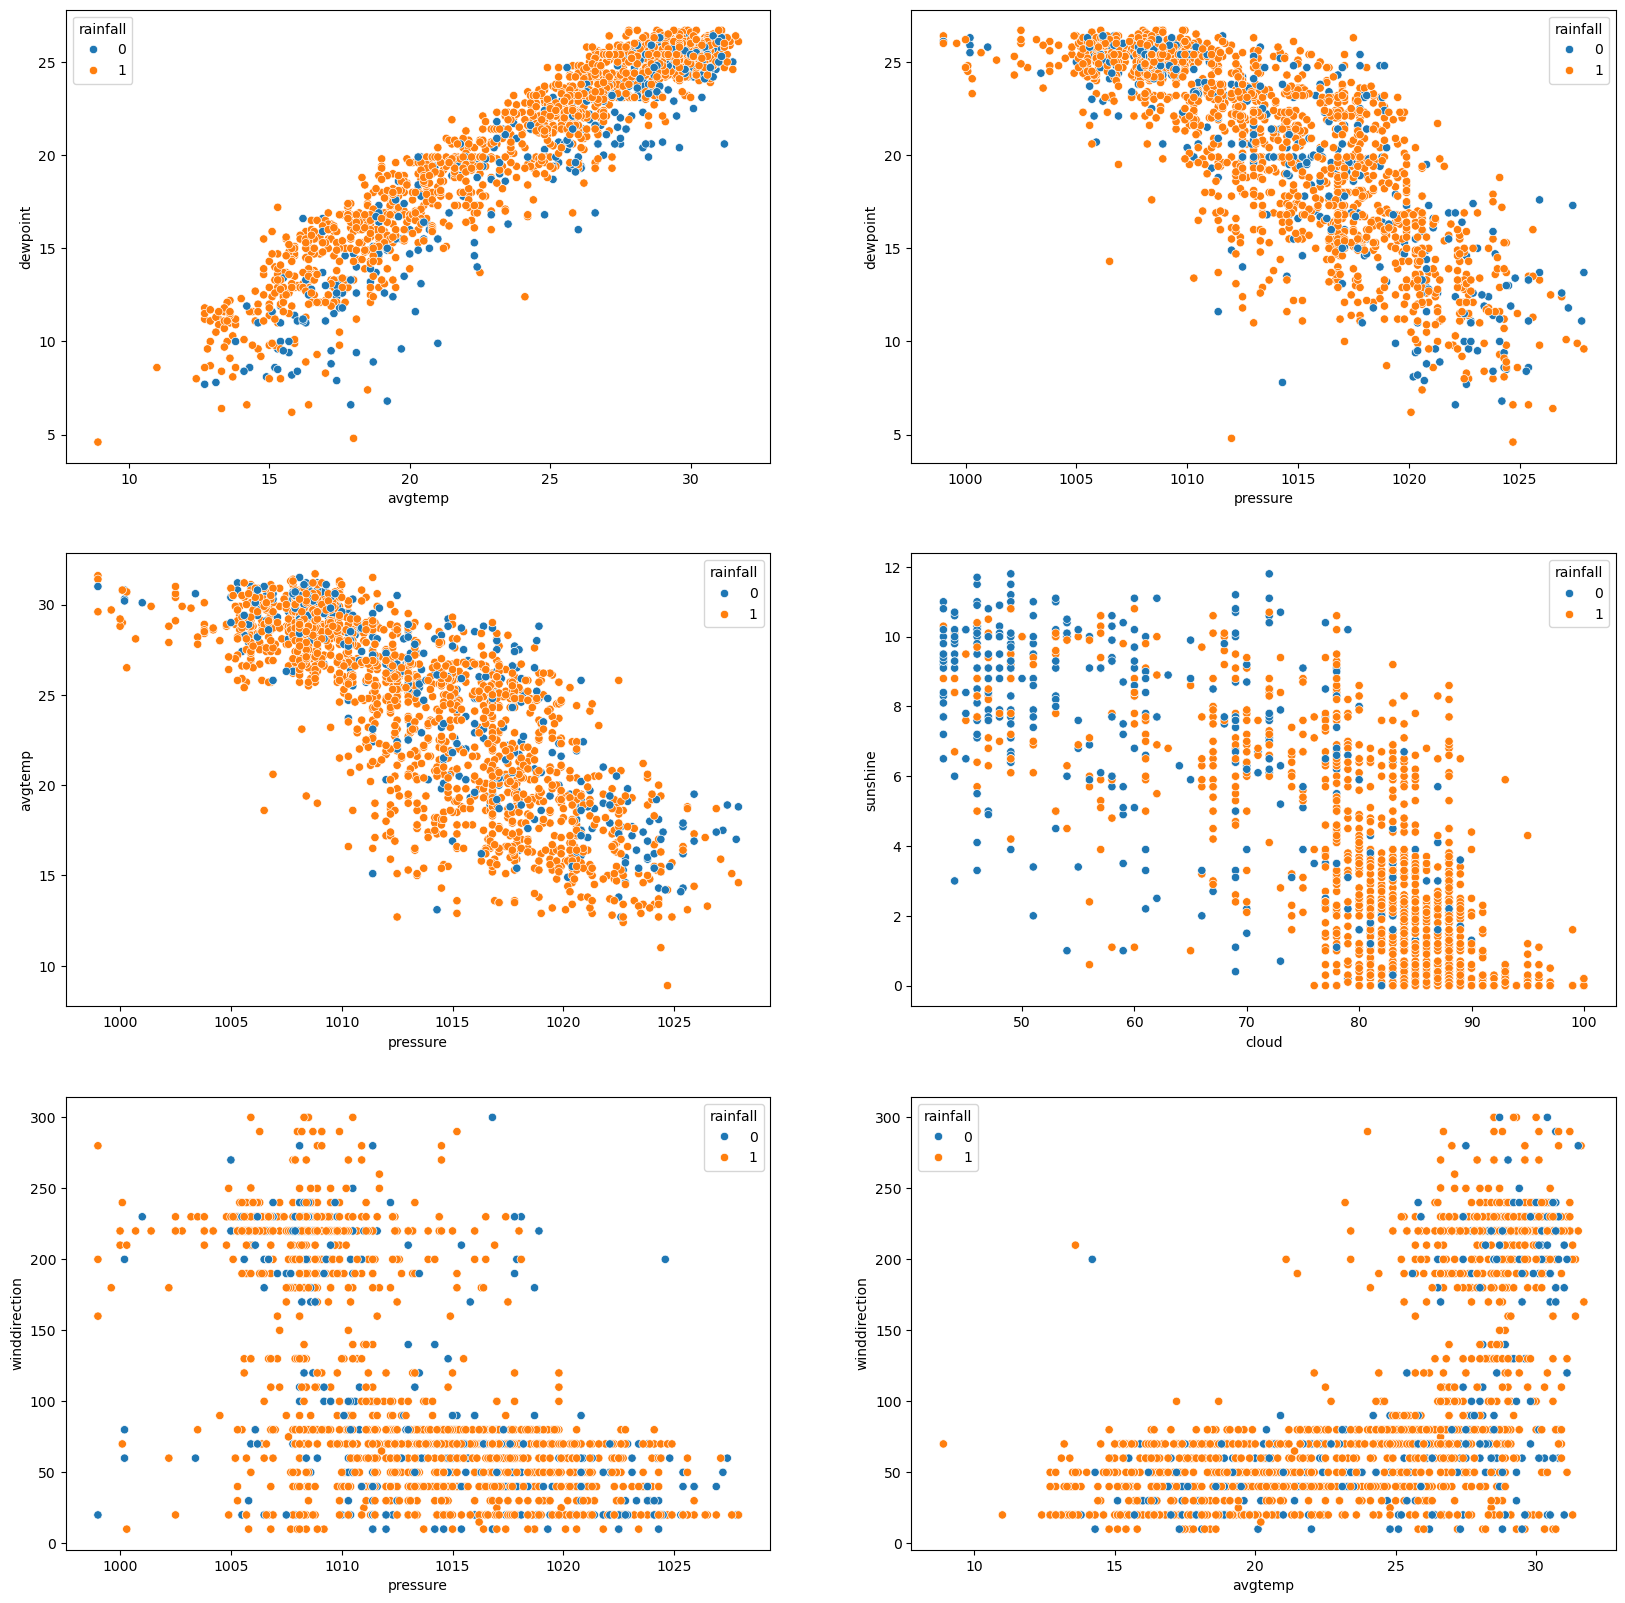

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
sns.scatterplot(data=data, x='avgtemp', y='dewpoint', hue='rainfall', ax=axes[0][0])
sns.scatterplot(data=data, x='pressure', y='dewpoint', hue='rainfall', ax=axes[0][1])
sns.scatterplot(data=data, x='pressure', y='avgtemp', hue='rainfall', ax=axes[1][0])
sns.scatterplot(data=data, x='cloud', y='sunshine', hue='rainfall', ax=axes[1][1])
sns.scatterplot(data=data, x='pressure', y='winddirection', hue='rainfall', ax=axes[2][0])
sns.scatterplot(data=data, x='avgtemp', y='winddirection', hue='rainfall', ax=axes[2][1])
plt.show()

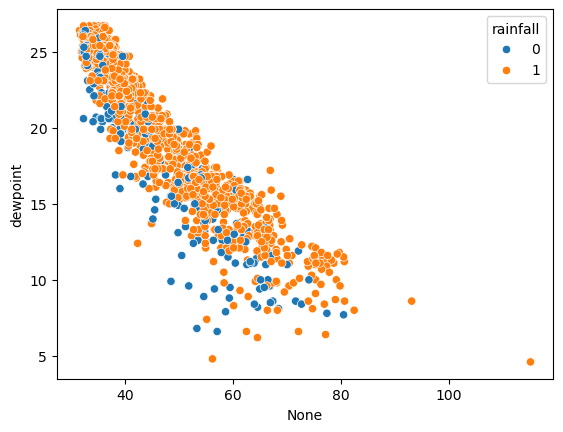

In [14]:
sns.scatterplot(y=data['dewpoint'], x=(data['pressure'] / data['avgtemp']), hue=data['rainfall']);

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('rainfall', axis=1), data['rainfall'], 
                                                    stratify=data['rainfall'], random_state=42)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train[X_train.columns] = sc.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = sc.transform(X_test[X_test.columns])

In [16]:
models = {
    'Logistic_Reg' : LogisticRegression(),
    'SVC' : LinearSVC(),
    'DT' : DecisionTreeClassifier(),
    'RF' : RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'Cat' : CatBoostClassifier(verbose=0),
    'LGB': LGBMClassifier(verbose=0),
}

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, data.drop('rainfall', axis=1), data['rainfall'], cv=cv, scoring="roc_auc")
    cv_scores[name] = scores
    print(f"{name}: Mean ROC-AUC = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}")

print("\nDetailed Scores:")
for name, scores in cv_scores.items():
    print(f"{name}: {scores}")

Logistic_Reg: Mean ROC-AUC = 0.8638, Std Dev = 0.0184
SVC: Mean ROC-AUC = 0.8597, Std Dev = 0.0211
DT: Mean ROC-AUC = 0.6616, Std Dev = 0.0225
RF: Mean ROC-AUC = 0.8453, Std Dev = 0.0141
XGB: Mean ROC-AUC = 0.8174, Std Dev = 0.0189
Cat: Mean ROC-AUC = 0.8503, Std Dev = 0.0181
LGB: Mean ROC-AUC = 0.8313, Std Dev = 0.0201

Detailed Scores:
Logistic_Reg: [0.88548259 0.83778045 0.88032853 0.86794872 0.84754573]
SVC: [0.87946994 0.83457532 0.88229167 0.86754808 0.83453038]
DT: [0.6606606  0.63826122 0.64559295 0.66029647 0.7032459 ]
RF: [0.8637856  0.834375   0.85290465 0.85134215 0.82431253]
XGB: [0.8429193  0.79306891 0.83365385 0.8010016  0.81627713]
Cat: [0.87278481 0.82516026 0.86911058 0.84495192 0.83956986]
LGB: [0.85684335 0.80016026 0.84887821 0.82199519 0.82849887]


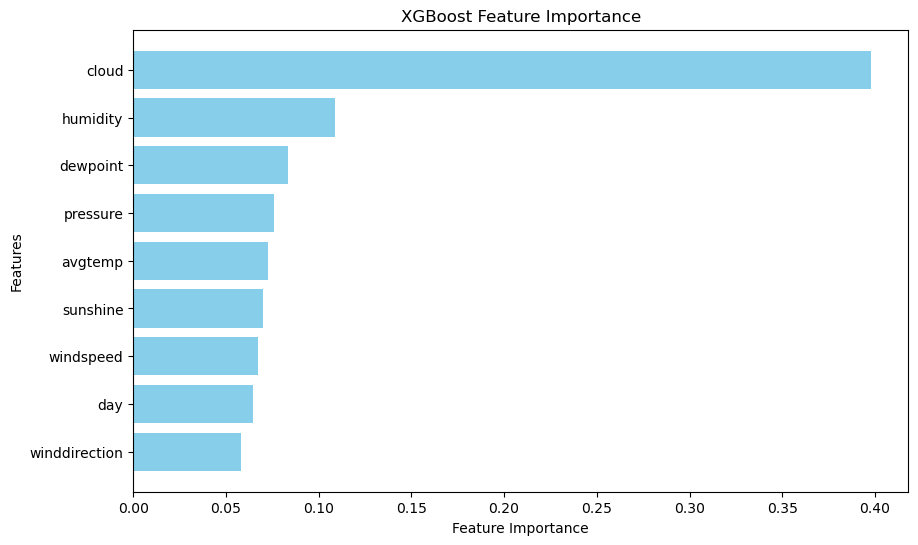

In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

importances = xgb.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

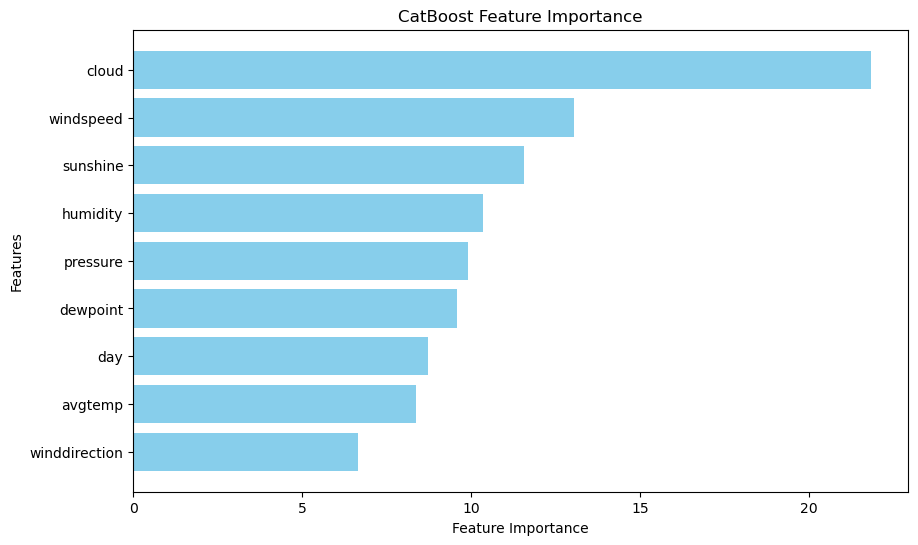

In [19]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)

importances = cat.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()

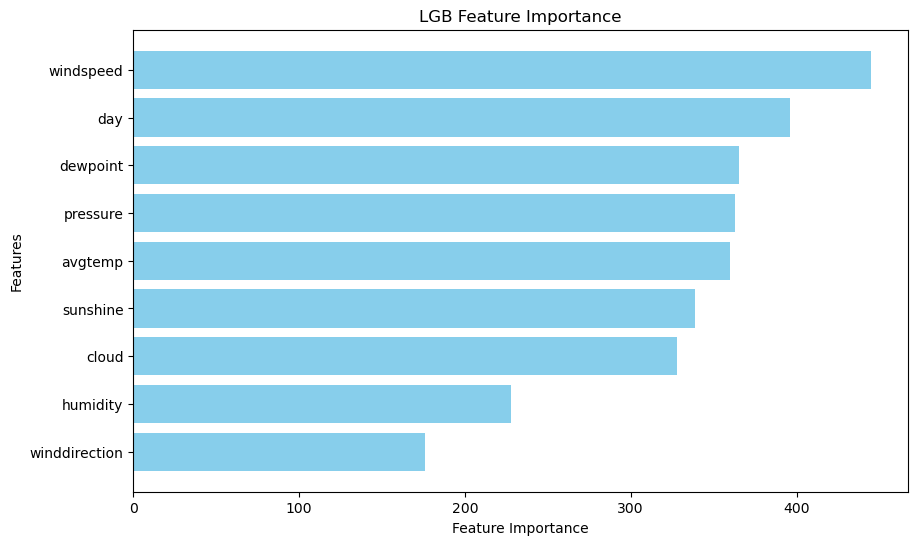

In [20]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

importances = lgb.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LGB Feature Importance")
plt.show()

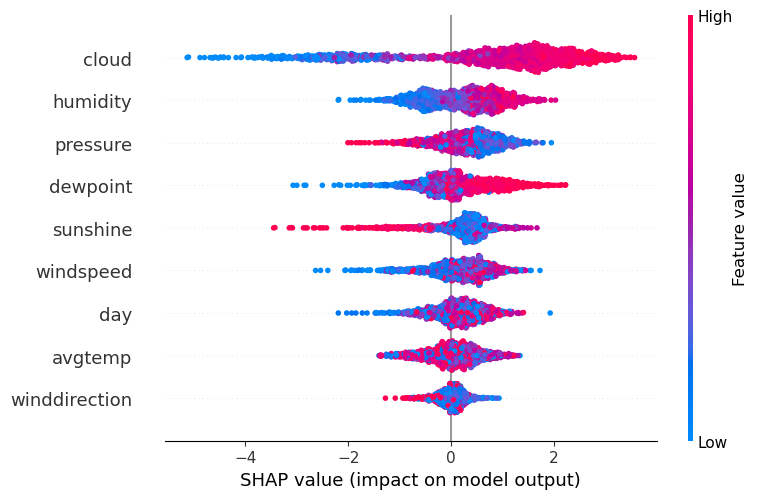

In [21]:
import shap

explainer = shap.TreeExplainer(xgb, feature_perturbation="tree_path_dependent")

shap_values = explainer.shap_values(X_train, check_additivity=False)  

shap.summary_plot(shap_values, X_train)

# Basic Log Reg

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8535459183673468

In [23]:
model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

LogisticRegression()

In [24]:
def process_test(data:pd.DataFrame):
    data['avgtemp'] = round((data['maxtemp'] + data['temparature'] + data['mintemp']) / 3, 1)
    data.drop(columns=['maxtemp', 'temparature', 'mintemp'], axis=1, inplace=True)
    # data.fillna(0)
    data[data.columns] = sc.transform(data[data.columns])
    data.fillna(0, inplace=True, axis=0)
    return data

In [25]:
test = pd.read_csv('./data/test.csv').set_index('id')

In [26]:
test = process_test(test)
test.head()

,day,pressure,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,avgtemp
id,,,,,,,,,
2190,-1.739310,1.138521,-1.221192,1.884316,1.456499,-0.993833,-0.694370,0.283304,-1.776999
2191,-1.729706,0.574774,-1.179500,2.030711,1.456499,-0.993833,-0.694370,1.458495,-1.518699
2192,-1.720102,1.965352,-2.471957,0.420360,1.239203,-0.993833,-0.821315,-0.507279,-2.770461
2193,-1.710498,1.777436,-2.346880,-1.189991,-2.454828,1.118095,-1.075205,3.093080,-1.300138
2194,-1.700893,1.645895,-3.430876,-2.214760,-2.165101,1.742749,-1.075205,-0.240190,-2.412815


In [27]:
submission = model.predict_proba(test)[:, 1]
subfile = pd.read_csv('./data/sample_submission.csv')
subfile['rainfall'] = submission

subfile.to_csv('./submission/LogRegBase.csv', index=False)

subfile.head()

,id,rainfall
0,2190,0.977796
1,2191,0.983890
2,2192,0.909057
3,2193,0.119159
4,2194,0.032082


In [29]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, show_progress_bar=True)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
best_clf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict_proba(X_test)[:, 1]
accuracy = roc_auc_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

[I 2025-03-01 14:34:14,398] A new study created in memory with name: no-name-da96b51f-441d-481b-b73e-65260843b3d0


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-03-01 14:34:16,335] Trial 0 finished with value: 0.8539808309577788 and parameters: {'n_estimators': 284, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.6279991533652655}. Best is trial 0 with value: 0.8539808309577788.
[I 2025-03-01 14:34:17,556] Trial 1 finished with value: 0.8573208233260757 and parameters: {'n_estimators': 185, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 0.8289067034237207}. Best is trial 1 with value: 0.8573208233260757.
[I 2025-03-01 14:34:19,093] Trial 2 finished with value: 0.855316378981392 and parameters: {'n_estimators': 483, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 0.4505473424345203}. Best is trial 1 with value: 0.8573208233260757.
[I 2025-03-01 14:34:19,822] Trial 3 finished with value: 0.8486206819151085 and parameters: {'n_estimators': 113, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 0.6213622812861

In [30]:
params = {'n_estimators': 499, 'max_depth': 20, 
          'min_samples_split': 5, 'min_samples_leaf': 6, 
          'max_features': 0.4970916271134286}

model1 = RandomForestClassifier(**params)

model1.fit(X_train, y_train)
roc_auc_score(y_test, model1.predict_proba(X_test)[:, 1])

0.851326530612245

In [35]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0),
        # "tree_method":"gpu_hist",
        # "devices":'0'
    }
    
    clf = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
best_clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict_proba(X_test)[:, 1]
accuracy = roc_auc_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

[I 2025-03-01 14:47:18,043] A new study created in memory with name: no-name-7fcbd52a-27e8-4027-8569-b03544c5568f


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-03-01 14:47:18,112] Trial 0 finished with value: 0.8610907450722903 and parameters: {'n_estimators': 155, 'max_depth': 18, 'learning_rate': 0.05539192843292762, 'subsample': 0.6224674908609381, 'colsample_bytree': 0.5846345172074142, 'gamma': 3.3454313432523985, 'min_child_weight': 4, 'lambda': 2.1071580699668178, 'alpha': 5.346166413373111}. Best is trial 0 with value: 0.8610907450722903.
[I 2025-03-01 14:47:18,214] Trial 1 finished with value: 0.8579169616445235 and parameters: {'n_estimators': 427, 'max_depth': 15, 'learning_rate': 0.0120845426382828, 'subsample': 0.5880688303747903, 'colsample_bytree': 0.9324989037216854, 'gamma': 4.006731685670088, 'min_child_weight': 7, 'lambda': 9.07494474834896, 'alpha': 7.711404401846101}. Best is trial 0 with value: 0.8610907450722903.
[I 2025-03-01 14:47:18,262] Trial 2 finished with value: 0.8606447574028744 and parameters: {'n_estimators': 128, 'max_depth': 17, 'learning_rate': 0.11010040603500779, 'subsample': 0.8446923386522813, 

In [36]:
params =    {'n_estimators': 93, 'max_depth': 20, 'learning_rate': 0.027123029711386998, 
             'subsample': 0.981593750063191, 'colsample_bytree': 0.7751554847481027, 
             'gamma': 0.2530833529943241, 'min_child_weight': 3, 'lambda': 4.721066915419485, 
             'alpha': 2.7905132243613826}

            
model2 = XGBClassifier(**params)
model2.fit(X_train, y_train)

roc_auc_score(y_test, model2.predict_proba(X_test)[:, 1])

0.852984693877551

In [44]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "verbose":-1
    }
    
    clf = LGBMClassifier(**params)
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1, verbose=0).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
best_clf = LGBMClassifier(**best_params)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict_proba(X_test)[:, 1]
accuracy = roc_auc_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

[I 2025-03-01 14:59:02,109] A new study created in memory with name: no-name-6aee8eac-3476-4ccd-ad35-090c1218f2bb


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-03-01 14:59:02,360] Trial 0 finished with value: 0.8540273958519287 and parameters: {'n_estimators': 180, 'max_depth': 8, 'learning_rate': 0.01028177365891492, 'num_leaves': 176, 'subsample': 0.5140289492462671, 'colsample_bytree': 0.914491414335328, 'reg_alpha': 7.7272257177838535, 'reg_lambda': 8.056625411893855, 'min_child_samples': 1}. Best is trial 0 with value: 0.8540273958519287.
[I 2025-03-01 14:59:02,526] Trial 1 finished with value: 0.8583414307047598 and parameters: {'n_estimators': 212, 'max_depth': 6, 'learning_rate': 0.08018671575020646, 'num_leaves': 162, 'subsample': 0.9234137415385637, 'colsample_bytree': 0.6669429535468718, 'reg_alpha': 4.212873167135299, 'reg_lambda': 8.869276962950956, 'min_child_samples': 75}. Best is trial 1 with value: 0.8583414307047598.
[I 2025-03-01 14:59:02,896] Trial 2 finished with value: 0.8548380760066744 and parameters: {'n_estimators': 333, 'max_depth': 10, 'learning_rate': 0.03676550867742121, 'num_leaves': 91, 'subsample': 0.8

In [45]:
params = {'n_estimators': 331, 'max_depth': 12, 'learning_rate': 0.08487661176738037, 'num_leaves': 166,
           'subsample': 0.5960443979816741, 'colsample_bytree': 0.6743393404103202, 'reg_alpha': 7.169819621428156, 
           'reg_lambda': 4.9190517223292245, 'min_child_samples': 65}

model3 = LGBMClassifier(**params)
model3.fit(X_train, y_train)

roc_auc_score(y_test, model3.predict_proba(X_test)[:, 1])

0.8579336734693878

In [47]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 500),
        "depth": trial.suggest_int("depth", 2, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0),
        # "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "task_type": "GPU",
    }
    
    clf = CatBoostClassifier(**params, verbose=0)
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()
    return score

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
best_clf = CatBoostClassifier(**best_params, verbose=0)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict_proba(X_test)[:, 1]
accuracy = roc_auc_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

[I 2025-03-01 15:06:38,590] A new study created in memory with name: no-name-0f6b9a45-a798-4c26-b85b-802c8b9297fe


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-03-01 15:06:40,597] Trial 0 finished with value: 0.8512940225808624 and parameters: {'iterations': 386, 'depth': 4, 'learning_rate': 0.14766724618486243, 'l2_leaf_reg': 3.5246449825525517, 'border_count': 221, 'bagging_temperature': 0.29923951724621467, 'random_strength': 4.657439987689108}. Best is trial 0 with value: 0.8512940225808624.
[I 2025-03-01 15:06:43,182] Trial 1 finished with value: 0.8559852753024624 and parameters: {'iterations': 66, 'depth': 10, 'learning_rate': 0.014204101554963267, 'l2_leaf_reg': 3.1031624792686294, 'border_count': 205, 'bagging_temperature': 0.5604346286660951, 'random_strength': 9.685786945186349}. Best is trial 1 with value: 0.8559852753024624.
[I 2025-03-01 15:06:45,630] Trial 2 finished with value: 0.8506183924042109 and parameters: {'iterations': 272, 'depth': 10, 'learning_rate': 0.030714700853848167, 'l2_leaf_reg': 2.2661376050505853, 'border_count': 40, 'bagging_temperature': 0.382997642673657, 'random_strength': 3.0570696717312877}. B

In [49]:
params = {'iterations': 360, 'depth': 2, 'learning_rate': 0.02210003782641798,
          'l2_leaf_reg': 7.7966885537155, 'border_count': 140, 'bagging_temperature': 0.6001430186097687, 
          'random_strength': 8.871379893492033, 'verbose':0}


model4 = CatBoostClassifier(**params)
model4.fit(X_train, y_train)

roc_auc_score(y_test, model4.predict_proba(X_test)[:, 1])

0.8576785714285714

In [50]:
from sklearn.ensemble import StackingClassifier

final_model = LogisticRegression()

stack = StackingClassifier(
    estimators=[
        ('rf', model1),
        ('xgb', model2),
        ('lgb', model3),
        ('cat', model4),
    ],
    final_estimator=final_model,
    cv=5
)

stack.fit(X_train, y_train)
roc_auc_score(y_test, stack.predict_proba(X_test)[:, 1])

0.8598469387755101

In [52]:
stack.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

submission = stack.predict_proba(test)[:, 1]
subfile['rainfall'] = submission

subfile.to_csv('./submission/Optunas_Stacked.csv', index=False)
subfile.head()

,id,rainfall
0,2190,0.944142
1,2191,0.944368
2,2192,0.902244
3,2193,0.188005
4,2194,0.113007


In [53]:
stack

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=20,
                                                       max_features=0.4970916271134286,
                                                       min_samples_leaf=6,
                                                       min_samples_split=5,
                                                       n_estimators=499)),
                               ('xgb',
                                XGBClassifier(alpha=2.7905132243613826,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7751554847481027,
                                              device=None...
                               ('lgb',
                                LGBMClassifier(colsample_bytree=0.6743393404103202,
                                               learning_rate=0.08487661176738037,
                                               max_depth=12,
                                               min_child_samples=65,
                                               n_estimators=331, num_leaves=166,
                                               reg_alpha=7.169819621428156,
                                               reg_lambda=4.9190517223292245,
                                               subsample=0.5960443979816741)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000002E0FBB6CF10>)],
                   final_estimator=LogisticRegression())